In [16]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import glob
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from google.colab import drive
from os import path
drive.mount('/content/drive')

data_root = './drive/MyDrive/NAS/CSED538/DL20'
print(path.exists(data_root))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [17]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=20):
    super(SimpleCNN, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc    = nn.Linear(128*16*16, 20)
  def forward(self, x):
    # Convolution Feature Extraction Part
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    # Fully Connected Classifier Part
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [33]:
# Network
model = SimpleCNN(num_classes=20)

# Random input
x = torch.randn((1, 3, 64, 64))
out = model(x)
print("Output tensor shape is :", out.shape)

Output tensor shape is : torch.Size([1, 20])


In [34]:
class LoadDataset(Dataset):
    def __init__(self, data_path, transform, mode='train'):
        super(LoadDataset, self).__init__()
        self.data_path = data_path
        self.mode = mode
        self.transform = transform
        
        if mode == "test":
            self.test_load()
        else : 
            self.load_dataset()

    def test_load(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = glob.glob(root+"/*.png")
        
    def load_dataset(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = ImageFolder(root=root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == "test":
            img = Image.open(self.data[index]).convert('RGB')
            img = self.transform(img)
            return img
        else:
            img, label = self.data[index]
            img, label = self.transform(img), int(label)
            return img, label

In [35]:
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 32
train_dataset = LoadDataset(data_root, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

root :  ./drive/MyDrive/NAS/CSED538/DL20/train


In [36]:
learning_rate = 5 * 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model.train()
train_loss, train_accu = [], []
valid_loss, valid_accu = [], []
epoch = 20
for e in range(epoch):
  train_iter = 0
  for image, label in train_loader:
    image, label = Variable(image), Variable(label)

    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()   

    prediction = torch.argmax(output, dim=-1)
    accuracy = prediction.eq(label.data).sum()/batch_size*100
    train_accu.append(accuracy)
    if (e % 1 == 0) and (train_iter % 100 == 0):
      print(f'Epoch: {e}\tTrain Step: {train_iter}\tLoss: {loss:.3f}\tAccuracy: {accuracy:.3f}')
    train_iter += 1
  if (e % 3 == 0):
    torch.save(model.state_dict(), path.join(data_root, f'simpleCNN_{e}.pth'))

Epoch: 0	Train Step: 0	Loss: 3.173	Accuracy: 3.125
Epoch: 0	Train Step: 100	Loss: 7.392	Accuracy: 9.375
Epoch: 0	Train Step: 200	Loss: 2.742	Accuracy: 15.625
Epoch: 1	Train Step: 0	Loss: 2.579	Accuracy: 28.125
Epoch: 1	Train Step: 100	Loss: 2.364	Accuracy: 31.250
Epoch: 1	Train Step: 200	Loss: 2.134	Accuracy: 43.750
Epoch: 2	Train Step: 0	Loss: 2.579	Accuracy: 21.875
Epoch: 2	Train Step: 100	Loss: 2.186	Accuracy: 34.375
Epoch: 2	Train Step: 200	Loss: 2.264	Accuracy: 37.500
Epoch: 3	Train Step: 0	Loss: 2.007	Accuracy: 34.375
Epoch: 3	Train Step: 100	Loss: 1.666	Accuracy: 43.750
Epoch: 3	Train Step: 200	Loss: 2.112	Accuracy: 37.500
Epoch: 4	Train Step: 0	Loss: 1.958	Accuracy: 37.500
Epoch: 4	Train Step: 100	Loss: 1.429	Accuracy: 56.250
Epoch: 4	Train Step: 200	Loss: 1.841	Accuracy: 50.000
Epoch: 5	Train Step: 0	Loss: 1.589	Accuracy: 62.500
Epoch: 5	Train Step: 100	Loss: 2.247	Accuracy: 37.500
Epoch: 5	Train Step: 200	Loss: 1.467	Accuracy: 65.625
Epoch: 6	Train Step: 0	Loss: 0.932	Accurac

In [37]:
batch_size = 32
valid_dataset = LoadDataset(data_root, transform, "valid")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

model.eval()
epoch = 1
for e in range(epoch):
  valid_iter = 0
  for image, label in valid_loader:
    image, label = Variable(image), Variable(label)

    output = model(image)
    prediction = torch.argmax(output, dim=-1)
    accuracy = prediction.eq(label.data).sum()/batch_size*100
    valid_accu.append(accuracy)
    if (e % 1 == 0) and (train_iter % 100 == 0):
      print(f'Epoch: {e}\tTrain Step: {valid_iter}\tAccuracy: {accuracy:.3f}')
    valid_iter += 1

root :  ./drive/MyDrive/NAS/CSED538/DL20/valid


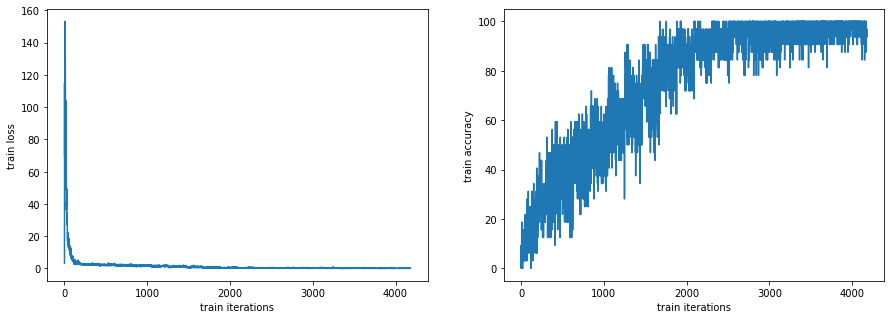

30.188679


In [47]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_ylabel('train loss')
ax1.set_xlabel('train iterations')
ax1.plot(range(len(train_loss)), train_loss)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_ylabel('train accuracy')
ax2.set_xlabel('train iterations')
ax2.plot(range(len(train_accu)), train_accu)
plt.show()
print(np.mean(valid_accu))